## FIT5202 : Week 11 - Spark Structured Streaming
In this lab today, we will look into additional concepts in Spark Structured Streaming like, using File-Sink, implementing windowed aggregations on the streams, handling late event-time data and checkpointing.

## Table of Contents

* [Write stream output to a parquet file](#parquet)
* [Aggregations on Windows over Event-time](#agg)
* [Handling Late Events with Watermarking](#water)
* [Recovering from Failures with Checkpointing](#checkpoint)    
* [Lab Tasks](#lab-task-1)
    * <a href="./Lab%20Task%20-%20Log%20Analysis.ipynb" target="_blank">Lab Task 1 (Log Analysis Window Aggregation)</a>    

### Step 1
Initialize Spark Session

In [94]:
import os
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages org.apache.spark:spark-streaming-kafka-0-10_2.12:3.4.0,org.apache.spark:spark-sql-kafka-0-10_2.12:3.4.0 pyspark-shell'

from pyspark.sql import SparkSession
from pyspark.sql.functions import explode
from pyspark.sql.functions import *
from pyspark.sql import functions as F
from pyspark.sql.types import *



spark = SparkSession \
    .builder \
    .appName("Clickstream Analysis in Spark") \
    .getOrCreate()


### Step 2
Connection to Kafka Producer/Broker and subscribe to the topic and load data from Kafka topic with <code>readStream</code>

In [95]:
topic = "clickstream"
#configuration
hostip = "192.168.1.87" #change me

df = spark \
    .readStream \
    .format("kafka") \
    .option("kafka.bootstrap.servers", f"{hostip}:9092") \
    .option("subscribe", topic) \
    .load()

### Step 3 
Converting the key/value from the kafka data stream to string

In [96]:
df = df.selectExpr("CAST(key AS STRING)", "CAST(value AS STRING)")

### Step 4
Converting the incoming stream into dataframe based on the schema. Note that, were are receiving a list from the producer, so the schema and other transformations are done accordingly

In [97]:
#Define the schema for the structured datastream received
schema = ArrayType(StructType([    
    StructField('Clicks', IntegerType(), True), 
    StructField('Impressions', IntegerType(), True),
    StructField('ts', TimestampType(), True)            
]))

In [98]:
df=df.select(F.from_json(F.col("value").cast("string"), schema).alias('parsed_value'))
df = df.select(F.explode(F.col("parsed_value")).alias('unnested_value'))  
df_formatted = df.select(
                    F.col("unnested_value.Clicks").alias("Clicks"),
                    F.col("unnested_value.Impressions").alias("Impressions"),
                    F.col("unnested_value.ts").alias("ts")
                )

In [99]:
df_formatted.printSchema()

root
 |-- Clicks: integer (nullable = true)
 |-- Impressions: integer (nullable = true)
 |-- ts: timestamp (nullable = true)



### Write stream output to a parquet file (<a href="https://spark.apache.org/docs/latest/structured-streaming-programming-guide.html#output-sinks" target="_blank">File Sink</a>) <a class="anchor" name="parquet"></a>
Parquet is a columnar file format that provides optimizations to speed up queries and is far more efficient file format than csv or json. We can <code>format("parquet")</code> to save the query to the parquet file.

In [100]:
# Write into parquet files the unsuccessful requests partitioned by status code
query_file_sink = df_formatted.writeStream.format("parquet")\
        .outputMode("append")\
        .option("path", "parquet/clickstream_df")\
        .option("checkpointLocation", "parquet/clickstream_df/checkpoint")\
        .start()

In [101]:
#Stop the file_sink query
query_file_sink.stop()

#### Read the saved parquet data

In [102]:
# Read the saved parquet data
query_file_sink_df = spark.read.parquet("parquet/clickstream_df")
query_file_sink_df.printSchema()
query_file_sink_df.show()

root
 |-- Clicks: integer (nullable = true)
 |-- Impressions: integer (nullable = true)
 |-- ts: timestamp (nullable = true)

+------+-----------+-------------------+
|Clicks|Impressions|                 ts|
+------+-----------+-------------------+
|     0|          3|2023-10-08 05:40:13|
|     0|          3|2023-10-08 05:40:13|
|     0|          4|2023-10-08 05:40:13|
|     0|          2|2023-10-08 05:40:13|
|     0|          4|2023-10-08 05:40:13|
|     0|          3|2023-10-08 05:40:13|
|     0|          7|2023-10-08 05:40:13|
|     0|          4|2023-10-08 05:40:13|
|     0|          4|2023-10-08 05:40:08|
|     1|          8|2023-10-08 05:40:08|
|     0|         11|2023-10-08 05:40:08|
|     0|          6|2023-10-08 05:40:18|
|     0|          7|2023-10-08 05:40:18|
|     0|          6|2023-10-08 05:40:18|
|     0|          4|2023-10-08 05:40:18|
|     0|          4|2023-10-08 05:40:18|
|     0|          7|2023-10-08 05:40:18|
|     0|          0|2023-10-08 05:40:18|
|     0|     

Here, we have defined a 10 seconds window, to count the number of impressions every 10 seconds. 5 seconds is the overlapping window.

### Aggregations on Windows over Event-time <a class="anchor" name="agg"></a>
Instead of running aggregations over the whole stream, we can aggregate over data bucketed by time window (e.g. every 10 secs). For example, in our use case, we want to calculate the total impressions received by the ad in the last 10 seconds. This 10 second window will be based on the timestamp embedded in the data i.e. <code>ts</code> which we have generated on the producer's side and not the time it is being processed (aka. processing-time).

In [103]:
windowedCounts = df_formatted \
    .groupBy(window(df_formatted.ts, "10 seconds"))\
    .agg(F.sum("Impressions").alias("total"))\
    .select("window","total")

### Handling Late Events with Watermarking <a href="https://spark.apache.org/docs/latest/structured-streaming-programming-guide.html#handling-late-data-and-watermarking" target="_BLANK">[Ref]</a><a class="anchor" name="water"></a>
When we are considering event-time, sometimes the data may arrive later than expected. However, we cannot include the data in our current window aggregate if it doesn't fall in the window range. The previous aggregate i.e. old window, where the data falls into needs to be updated appropriately. The concept of <strong>Watermarking</strong> lets the engine automatically track the current event time in the data and update the aggregate window and the states accordingly.

We can define the watermark of a query by specifying the event time column and the threshold on how late the data is expected to be in terms of eventtime.

In [109]:
windowedCounts = df_formatted \
    .withWatermark("ts", "10 seconds") \
    .groupBy(window(df_formatted.ts, "10 seconds"))\
    .agg(F.sum("Impressions").alias("total"))\
    .select("window","total")

In [110]:
windowedCounts.printSchema()

root
 |-- window: struct (nullable = false)
 |    |-- start: timestamp (nullable = true)
 |    |-- end: timestamp (nullable = true)
 |-- total: long (nullable = true)



In [112]:
query = windowedCounts \
    .writeStream \
    .outputMode("complete") \
    .format("console") \
    .trigger(processingTime='5 seconds') \
    .option("truncate","false")\
    .start()

In the console, you should be able to see output like this.
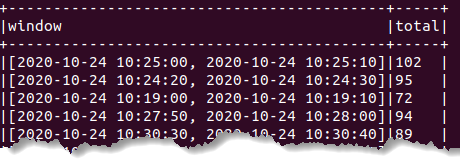

In [107]:
query.stop()

### Recovering from Failures with Checkpointing <a href="https://spark.apache.org/docs/latest/structured-streaming-programming-guide.html#recovering-from-failures-with-checkpointing" target="_blank">[Ref]</a><a class="anchor" name="checkpoint"></a>
In case of a failure or intentional shutdown, you can recover the previous progress and state of a previous query, and continue where it left off. This is done using checkpointing and write-ahead logs. You can configure a query with a checkpoint location, and the query will save all the progress information (i.e. range of offsets processed in each trigger) and the running aggregates (e.g. word counts in the quick example) to the checkpoint location.

For example, we have set a checkpoint for the query above i.e. writing to parquet sink.
<code>
    # Write into parquet files the unsuccessful requests partitioned by status code
    query2 = df_formatted.writeStream.format("parquet")\
            .outputMode("append")\
            .option("path", "parquet/clickstream_df")\
            .option("checkpointLocation", "parquet/clickstream_df/checkpoint")\
            .start()
</code>